In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { margin-left: 0 !important; width:100% !important; }</style>"))

In [2]:
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import json
from types import SimpleNamespace
import cmath
import glob
import itertools
import tensorboard
from datetime import datetime

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [ ]:
#tf.autograph.set_verbosity(10)

In [3]:
# example0:
# {
#   "EntryType":"EquivalentLoudnessMeasurement",
#   "Calibration":{
#     "HeadphoneFrequencyResponseHash":"eab807a5050b0087109ac1fd6fecbd09197a3dcd",
#     "FullScaleSineDBSPL":100
#   },
#   "Run":{
#     "ID":"1599737802659_2857050667"
#   },
#   "Evaluation":{
#     "ID":"1599738237070_2365796582",
#     "Frequency":697.9866246810275,
#     "Probe":{
#       "Type":"Noise",
#       "Params":{
#         "Level":-10,
#         "LowerLimit":966.84025,
#         "Onset":{
#           "Delay":0,
#           "Duration":0.1
#         },
#         "UpperLimit":1033.15975
#       }
#     },
#     "Combined":{
#       "Type":"Superposition",
#       "Params":[
#         {
#           "Params":{
#             "Level":-40,
#             "LowerLimit":966.84025,
#             "Onset":{
#               "Delay":0.5,
#               "Duration":0.1
#             },
#             "UpperLimit":1033.15975
#           },
#           "Type":"Noise"
#         },{
#           "Params":{
#             "Level":-20,
#             "LowerLimit":672.9766301106662,
#             "Onset":{
#               "Delay":0,
#               "Duration":0.1
#             },
#             "UpperLimit":722.9966192513888
#           },
#           "Type":"Noise"
#         }
#       ]
#     }
#   },
#   "Results":{
#     "ProbeGainForEquivalentLoudness":0.003107877399956887,
#     "ProbeDBSPLForEquivalentLoudness":39.84927756697657
#   }
# }
def experiment_result_to_example(js, car_fs_sine_level=100, window_size=2048, sample_rate=48000):
    exp = json.loads(js, object_hook=lambda o: SimpleNamespace(**o))
    if exp.EntryType != 'EquivalentLoudnessMeasurement':
        return None
    assert exp.Evaluation.Probe.Type == 'Noise'
    assert exp.Evaluation.Combined.Type == 'Superposition'
    for part in exp.Evaluation.Combined.Params:
        assert part.Type == 'Noise'
        # If this part isn't the probe.
        if (part.Params.LowerLimit != exp.Evaluation.Probe.Params.LowerLimit or
            part.Params.UpperLimit != exp.Evaluation.Probe.Params.UpperLimit):
            # We want to ignore evaluations where probe and masker overlap.
            if ((part.Params.LowerLimit >= exp.Evaluation.Probe.Params.LowerLimit and
                 part.Params.LowerLimit <= exp.Evaluation.Probe.Params.UpperLimit) or
                (part.Params.UpperLimit >= exp.Evaluation.Probe.Params.LowerLimit and
                 part.Params.UpperLimit <= exp.Evaluation.Probe.Params.UpperLimit) or
                (part.Params.LowerLimit <= exp.Evaluation.Probe.Params.LowerLimit and
                 part.Params.UpperLimit >= exp.Evaluation.Probe.Params.UpperLimit)):
                return None
    assert exp.Results.ProbeGainForEquivalentLoudness > 0
    assert exp.Results.ProbeDBSPLForEquivalentLoudness != None
    assert exp.Calibration.FullScaleSineDBSPL > 0

    bin_width = sample_rate / window_size
    def add_noise(coeffs, lower_limit, upper_limit, total_power_db_fs):
        first_bin = int(np.floor(lower_limit/bin_width))
        last_bin = int(np.ceil(upper_limit/bin_width))
        noise_coeffs = (complex(0, 1) * np.random.normal(size=[last_bin-first_bin]) + 
                        np.random.normal(size=[last_bin-first_bin]))
        noise_power_db_fs = 10 * np.log10(np.sum(noise_coeffs ** 2))
        scale = 10 ** ((total_power_db_fs - noise_power_db_fs) / 20)
        noise_coeffs *= scale
        for bin_idx in range(first_bin, first_bin + 1):
            coeffs[bin_idx] += noise_coeffs[bin_idx - first_bin]
            coeffs[-bin_idx] += np.conjugate(coeffs[bin_idx])
    coeffs = np.zeros([window_size], dtype=np.complex128)
    for part in exp.Evaluation.Combined.Params:
        part_db_spl = exp.Calibration.FullScaleSineDBSPL + part.Params.Level
        part_db_fs = part_db_spl - car_fs_sine_level
        add_noise(coeffs, part.Params.LowerLimit, part.Params.UpperLimit, part_db_fs)
    
    relevant_bins = np.zeros([int(window_size/2)], dtype=np.complex128)
    first_relevant_bin = int(np.floor(exp.Evaluation.Probe.Params.LowerLimit/bin_width))
    last_relevant_bin = int(np.ceil(exp.Evaluation.Probe.Params.UpperLimit/bin_width))
    for bin_idx in range(first_relevant_bin, last_relevant_bin + 1):
        relevant_bins[bin_idx] = 1

    true_loudness = np.array([exp.Results.ProbeDBSPLForEquivalentLoudness], dtype=np.complex128)
    
    res = tf.concat([coeffs, true_loudness, relevant_bins], axis=0)
    return res

def load_examples(glb, car_fs_sine_level=100, window_size=2048, sample_rate=48000):
    lines_iter = itertools.chain(*map(lambda f: open(f).readlines(), glob.glob(glb)))
    examples_iter = map(lambda l: experiment_result_to_example(l, car_fs_sine_level=car_fs_sine_level, window_size=window_size, sample_rate=sample_rate), lines_iter)
    filtered_iter = filter(lambda e: e != None, examples_iter)
    ds = tf.data.Dataset.from_tensor_slices(list(filtered_iter))
    input_true_ds = ds.map(lambda ex: (ex[:window_size], ex[window_size:]))
    return input_true_ds
            
def plot_pz(f):
    _, ax = plt.subplots(figsize=(8,8))
    ax.add_patch(patches.Circle((0,0),
                              radius=1,
                              fill=False,
                              color='black',
                              ls='solid',
                              alpha=0.1))
    ax.axvline(0, color='0.7')
    ax.axhline(0, color='0.7')
    ax.set_xlim((-1.1,1.1))
    ax.set_ylim((-1.1,1.1))

    ax.plot(tf.reshape(tf.math.real(f.poles), [-1,1]), tf.reshape(tf.math.imag(f.poles), [-1,1]),
            'x', markersize=9, alpha=0.5)
    ax.plot(tf.reshape(tf.math.real(f.zeros), [-1,1]), tf.reshape(tf.math.imag(f.zeros), [-1,1]),
            'o', color='none', markeredgecolor='red',
            markersize=9, alpha=0.5)

def plot_many_z(many_z, sample_rate=48000, figsize=(12,4)):
    xaxis = np.tile(np.linspace(0,
                                (many_z.shape[1] - 1) * sample_rate *
                                0.5 / many_z.shape[1],
                                many_z.shape[1]), [many_z.shape[0], 1])
    _, ax = plt.subplots(figsize=figsize)    
    ax.set_xscale('log')
    ax.set_xlim((10,20000))
    ax.set_ylim((-20, 70))
    x = np.transpose(xaxis[:,:xaxis.shape[1]//2])
    y = np.transpose(20 * np.log10(np.abs(many_z[:,:many_z.shape[1]//2])))
    ax.plot(x, y)
        
def plot_snr(snr):
    max_snr = np.nanmax(snr)
    min_snr = np.nanmin(snr)
    scaled_snr = ((snr - min_snr) / (max_snr - min_snr))[:,:,None]
    pixels = np.concatenate([scaled_snr, scaled_snr/2, scaled_snr/2], axis=2)
    plt.figure(figsize = (20,10))
    plt.imshow(pixels, interpolation='bicubic')
    
def plot_pred(model, ds):
    truth = []
    pred = []
    for ex in ds:
        x, y_true = ex
        for val in y_true[:,0]:
            truth.append(np.abs(val))
        y_pred = model(x)
        pred_min = np.min(y_pred, axis=1)[:,None]
        irrelevant_reduced = np.where(np.abs(y_true[:,1:]) != 0, y_pred, pred_min-1)
        for val in np.max(irrelevant_reduced, axis=1):
            pred.append(val)
    plt.figure(figsize=(20,10))
    steps = np.arange(len(truth))
    plt.plot(steps, truth)
    plt.plot(steps, pred)

def pz_filter(gain, poles, zeros, inputs):
    all_zeros = tf.concat([zeros, tf.math.conj(zeros)], axis=0)
    all_poles = tf.concat([poles, tf.math.conj(poles)], axis=0)
    z = tf.exp(tf.complex(tf.cast(0.0, tf.math.real(gain).dtype),
                          tf.linspace(
                              tf.cast(0.0, tf.math.imag(gain).dtype), 
                              # (inputs.shape[1] - 1) / inputs.shape[1] to not include 2*pi 
                              (inputs.shape[1] - 1)*2*math.pi/inputs.shape[1],
                              inputs.shape[1])), name='z')
    return (gain *
            tf.cast(inputs, gain.dtype) *
            tf.math.reduce_prod(z[None,:,None] - all_zeros[None,None,:], axis=2) /
            tf.math.reduce_prod(z[None,:,None] - all_poles[None,None,:], axis=2))

class CARLayer(tf.keras.layers.Layer):
    # See 'Human and Machine Hearing', 16.2-16.3,
    # and https://github.com/google/carfac/.
    def __init__(self, sample_rate=48000, erb_per_step=0.5, **kwargs):
        super().__init__(**kwargs)
        self._erb_per_step = erb_per_step
        self._sample_rate = sample_rate
        
        # Based on the assumtion that max small-signal gain at the passband peak
        # will be on the order of (0.5/min_zeta)^(1/erb_per_step), and we need
        # the start value of that in the same region or the loss function becomes
        # too uneven to optimize.
        def compute_zeta(zeta_at_default_erb_per_step, erb_per_step):
            default_erb_per_step = 0.5
            max_small_signal_gain = (0.5 /
                                     zeta_at_default_erb_per_step) ** (1 / default_erb_per_step)
            return 0.5 / (max_small_signal_gain ** erb_per_step)

        # Controls r (pole and zero abs value) which controls damping relative to
        # frequency.
        self._high_f_damping_compression = self.add_weight(
            name='high_f_damping_compression',
            initializer=tf.keras.initializers.Constant(0.5),
            trainable=self.trainable)
        # Controls distance from pole to zero.
        self._zero_ratio = self.add_weight(
            name='zero_ratio',
            initializer=tf.keras.initializers.Constant(2 ** 0.5),
            trainable=self.trainable)
        # min/max zeta controls max damping.
        self._min_zeta = self.add_weight(
            name='min_zeta',
            initializer=tf.keras.initializers.Constant(compute_zeta(0.1, self._erb_per_step)),
            trainable=self.trainable)
        self._max_zeta = self.add_weight(
            name='max_zeta',
            initializer=tf.keras.initializers.Constant(compute_zeta(0.35, self._erb_per_step)),
            trainable=self.trainable)
        # Controls how we convert from Hz to Cams.
        # Defaults at numbers from B.C.J. Moore and B.R. Glasberg, "Suggested formulae for calculating auditory-filter bandwidths and excitation patterns".
        self._erb_constant_0 = self.add_weight(
            name='erb_constant_0(24.7)',
            initializer=tf.keras.initializers.Constant(24.7),
            trainable=self.trainable)
        self._erb_constant_1 = self.add_weight(
            name='erb_constant_1(1.0)',
            initializer=tf.keras.initializers.Constant(1),
            trainable=self.trainable)
        self._erb_constant_2 = self.add_weight(
            name='erb_constant_2(4.37)',
            initializer=tf.keras.initializers.Constant(4.37),
            trainable=self.trainable)

    def get_config(self):
        config = super().get_config()
        config['erb_per_step'] = self._erb_per_step
        config['sample_rate'] = self._sample_rate
        return config
    # [...,fft_coeffs] => [...,channels,fft_coeffs]
    def call(self, inputs, **kwargs):
        max_freq = 20000
        min_freq = 20

        # Equivalent rectangular bandwidth, the width of the theoretical rectangular cochlear place filter.
        def ERB(f):
            return self._erb_constant_0 * (self._erb_constant_1 + self._erb_constant_2 * f * 0.001)

        pole_freqs_ta = tf.TensorArray(size=0, dynamic_size=True, dtype=self.dtype, clear_after_read=False)
        pole_freqs_ta = pole_freqs_ta.write(0, max_freq)
        while pole_freqs_ta.read(pole_freqs_ta.size()-1) - self._erb_per_step * ERB(pole_freqs_ta.read(pole_freqs_ta.size()-1)) > min_freq:
            pole_freqs_ta = pole_freqs_ta.write(pole_freqs_ta.size(), pole_freqs_ta.read(pole_freqs_ta.size()-1) - self._erb_per_step * ERB(pole_freqs_ta.read(pole_freqs_ta.size()-1)))
        pole_freqs = pole_freqs_ta.stack()
        n_poles = pole_freqs_ta.size()

        # From the matlab code:
        # zero_ratio comes in via h.  In book's circuit D, zero_ratio is 1/sqrt(a),
        # and that a is here 1 / (1+f) where h = f*c.
        # solve for f:  1/zero_ratio^2 = 1 / (1+f)
        # zero_ratio^2 = 1+f => f = zero_ratio^2 - 1
        f = tf.math.square(self._zero_ratio) - 1
        pole_thetas = pole_freqs * 2 * np.pi / self._sample_rate
        # The book assigns a0 and c0 thus to simplify the equations.
        a0 = tf.math.cos(pole_thetas)
        c0 = tf.math.sin(pole_thetas)

        # The ratio between each pole and max measurable frequency.
        x = pole_thetas / np.pi

        # From the matlab code:
        # When high_f_damping_compression is 0 this is just theta, when
        # high_f_damping_compression is 1 it approaches 0 as theta approaches pi.
        zr_coeffs = np.pi * (x - self._high_f_damping_compression * tf.math.pow(x, 3))

        # The book is not super easy to follow here, so I have mostly
        # implemented the same math as the matlab and c++ code.

        r1 = (1 - zr_coeffs * self._max_zeta)
        min_zetas = self._min_zeta + (0.25 * ((ERB(pole_freqs) / pole_freqs) - self._min_zeta))
        zr_coeffs *= (self._max_zeta - min_zetas)
        r = r1 + zr_coeffs
        h = c0 * f
        g0 = tf.cast((1 - 2 * r * a0 + tf.math.square(r)) / (1 - 2 * r * a0 + h * r * c0 + tf.math.square(r)), tf.complex128)
        self.poles = tf.cast(r, tf.complex128) * tf.exp(tf.complex(tf.cast(0, tf.float64), tf.cast(pole_thetas, tf.float64)))
        zero_thetas = tf.math.acos(a0 - h * c0 / 2)
        self.zeros = tf.cast(r, tf.complex128) * tf.exp(tf.complex(tf.cast(0, tf.float64), tf.cast(zero_thetas, tf.float64)))

        # Here is where I diverge a lot, by just creating frequency domain filters
        # instead of difference equations.
        res = tf.TensorArray(size=0, dynamic_size=True, dtype=tf.complex128, clear_after_read=False)
        tmp = tf.cast(inputs, tf.complex128)
        for idx in range(n_poles):
            tmp = pz_filter(g0[idx], self.poles[idx:idx+1], self.zeros[idx:idx+1], tmp)
            res = res.write(res.size(), tmp)
        res = res.stack()
        return tf.transpose(res, [1,0,2])

class OuterEarLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Numbers from https://colab.corp.google.com/drive/161a2riUCQeYYEPhlRc7XqtI9OWUMwQQX?usp=sharing.
        self.poles = self.add_weight(
            name='poles',
            dtype=tf.complex128,
            shape=[4],
            initializer=tf.keras.initializers.Constant([(-0.05429768147702485+1.4172655611120915e-05j),
                                                        (0.2917622403739163+0.7731812636894612j),
                                                        (0.8768382244780407-0.31120458350060115j),
                                                        (0.6598943546882394-0.46728573398560225j)]),
            trainable=self.trainable)
        self.zeros = self.add_weight(
            name='zeros',
            dtype=tf.complex128,
            shape=[3],
            initializer=tf.keras.initializers.Constant([(0.635496172349615+0.14499945287904842j),
                                                        (0.30987058966944614-0.8574194617385421j),
                                                        (0.5721096307971768-2.2915816453724273e-05j)]),
            trainable=self.trainable)
        self.gain = self.add_weight(
                name='gain',
                dtype=tf.complex128,
                initializer=tf.keras.initializers.Constant(1.34),
                trainable=self.trainable)
    # [...,fft_coeffs] => [...,channels,fft_coeffs]
    def call(self, inputs, **kwargs):
        return pz_filter(self.gain, self.poles, self.zeros, inputs)

class SNRLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    # [...,fft_coeffs] => [...,channels,db_snr]
    def call(self, inputs, **kwargs):
        gain = tf.math.abs(inputs)
        signal_power = tf.math.square(gain)
        noise_power = tf.math.reduce_sum(signal_power, axis=2)[:,:,None] - signal_power
        snr = tf.math.divide_no_nan(signal_power, noise_power)
        res = tf.cast(10.0, self.dtype) * tf.cast(tf.math.log(snr + 1e-16), self.dtype) / tf.cast(tf.math.log(10.0), self.dtype)
        res = res[:,:,:res.shape[2]//2]
        return res

class LoudnessPredictorLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        true_partial_loudness = y_true[:,0]
        relevant_bins = tf.cast(y_true[:,1:], tf.bool)
        min_psnr = tf.math.reduce_min(y_pred, axis=1)[:,None]
        reduced_irrelevant_bins = tf.where(relevant_bins, y_pred, min_psnr - 1)
        psnr_across_relevant_bins = tf.math.reduce_max(reduced_irrelevant_bins, axis=1)
        res = tf.keras.losses.MSE(true_partial_loudness, psnr_across_relevant_bins)
        return res

class LoudnessPredictorLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._loudness_offset = self.add_weight(
            name='loudness_offset',
            initializer=tf.keras.initializers.Constant(1),
            trainable=self.trainable,
        )
        self._loudness_scale = self.add_weight(
            name='loudness_scale',
            initializer=tf.keras.initializers.Constant(1),
            trainable=self.trainable,
        )
    # [...,fft_bin] => [...,equivalent_db_spl]
    def call(self, inputs, **kwargs):
        psnr_per_bin = tf.math.reduce_max(inputs, axis=1)
        res = self._loudness_offset * 60 + self._loudness_scale * 2 * psnr_per_bin
        return res


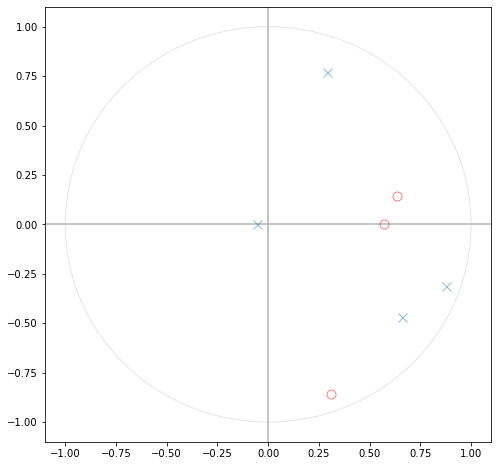

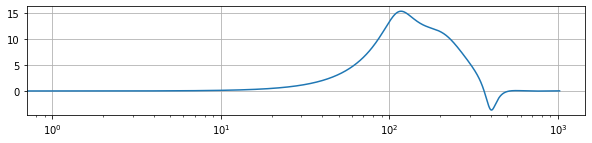

In [4]:
window_size = 2048
plot_pz(OuterEarLayer())
z = np.ones([1, 2048], dtype=np.complex128)
fy = tf.math.abs(OuterEarLayer()(z)[0])
y = 20 * np.log10(fy[:len(fy)//2])
plt.figure(figsize=(10,2))
plt.xscale('log')
plt.plot(np.arange(0, len(y)), y)
plt.grid(True)
plt.show()

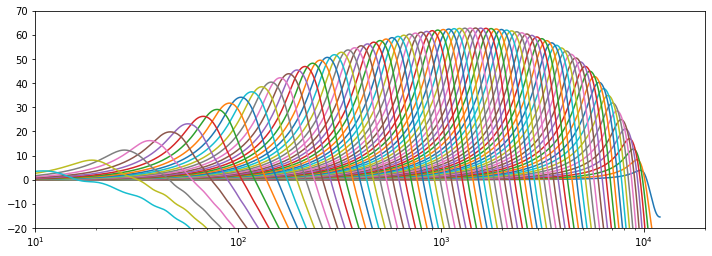

In [5]:
plot_many_z(CARLayer()(np.ones([1, 48000], dtype=np.complex128))[0])

(<tf.Tensor: shape=(128, 2048), dtype=complex128, numpy=
array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])>, <tf.Tensor: shape=(128, 1025), dtype=complex128, numpy=
array([[59.10062105+0.j,  0.        +0.j,  0.        +0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       [60.9036383 +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       [60.40222741+0.j,  0.        +0.j,  0.        +0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       ...,
       [51.69457251+0.j,  0.        +0.j,  0.        +0.j, ...,
         0.        +0.j,  0.        +0.j,  0.       

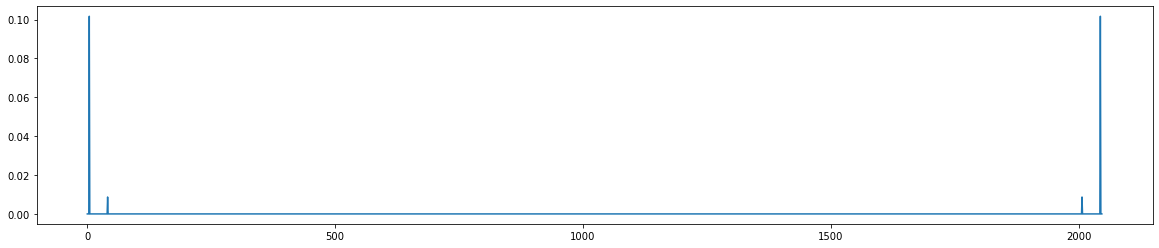

In [11]:
one_khz_examples = load_examples('/usr/local/google/home/zond/Drive/My Drive/korvapuusti/listening_tests/modern_format/by_probe_center/1kHz/*/*.json').batch(128)
for ex in one_khz_examples.take(1):
    ex0 = ex
print(ex)
plt.figure(figsize=(20,4))
plt.plot(np.arange(window_size), np.abs(ex0[0][0,:window_size]))
plt.show()

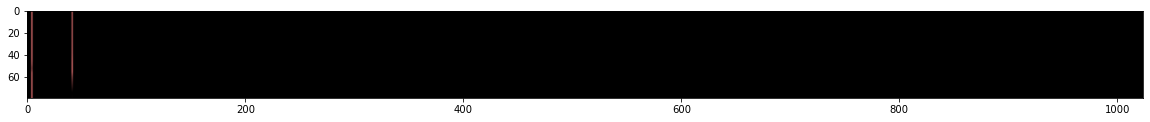

In [12]:
plot_snr(SNRLayer()(CARLayer()(OuterEarLayer()(ex0[0])))[0])

In [13]:
print(LoudnessPredictorLayer()(SNRLayer()(CARLayer()(OuterEarLayer()(ex0[0])))))

tf.Tensor(
[[-260. -260. -260. ... -260. -260. -260.]
 [-260. -260. -260. ... -260. -260. -260.]
 [-260. -260. -260. ... -260. -260. -260.]
 ...
 [-260. -260. -260. ... -260. -260. -260.]
 [-260. -260. -260. ... -260. -260. -260.]
 [-260. -260. -260. ... -260. -260. -260.]], shape=(128, 1024), dtype=float32)


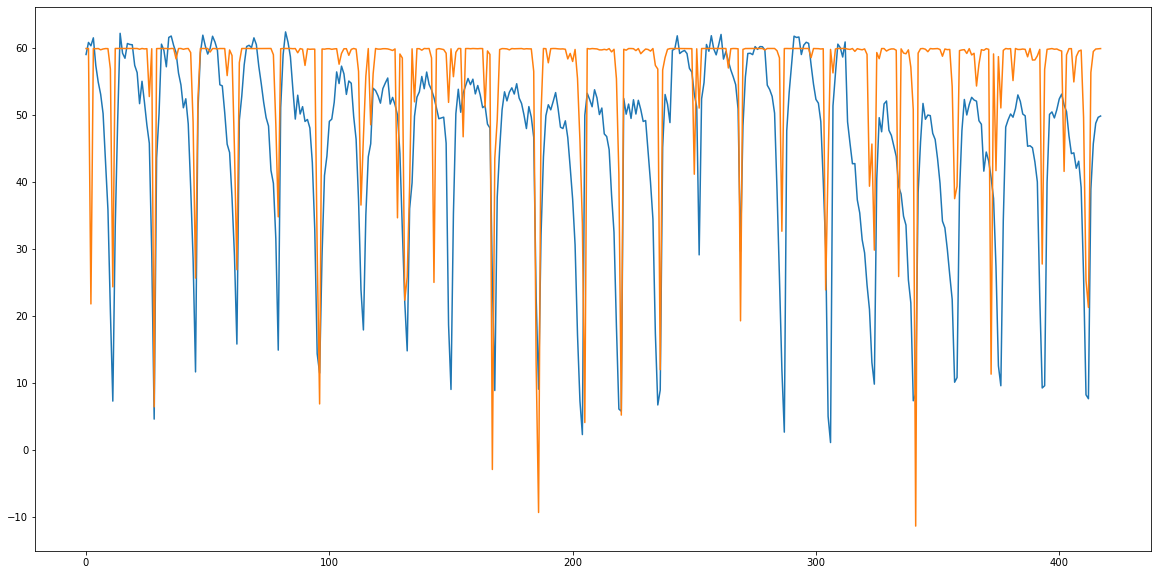

In [14]:
lpm = tf.keras.Sequential()
lpm.add(OuterEarLayer(input_shape=[window_size]))
lpm.add(CARLayer())
lpm.add(SNRLayer())
lpm.add(LoudnessPredictorLayer())
lpm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=LoudnessPredictorLoss())
plot_pred(lpm, one_khz_examples)

In [17]:
lpm.fit(one_khz_examples, epochs=100, verbose=2)

Epoch 1/100
4/4 - 2s - loss: 241.4568
Epoch 2/100
4/4 - 2s - loss: 240.8134
Epoch 3/100
4/4 - 2s - loss: 240.1722
Epoch 4/100
4/4 - 2s - loss: 239.5323
Epoch 5/100
4/4 - 2s - loss: 238.8854
Epoch 6/100
4/4 - 2s - loss: 238.2278
Epoch 7/100
4/4 - 2s - loss: 237.5665
Epoch 8/100
4/4 - 2s - loss: 236.9058
Epoch 9/100
4/4 - 2s - loss: 236.2621
Epoch 10/100
4/4 - 2s - loss: 235.6126
Epoch 11/100
4/4 - 2s - loss: 234.9265
Epoch 12/100
4/4 - 2s - loss: 234.2923
Epoch 13/100
4/4 - 2s - loss: 233.7099
Epoch 14/100
4/4 - 2s - loss: 233.1327
Epoch 15/100
4/4 - 2s - loss: 232.5596
Epoch 16/100
4/4 - 2s - loss: 231.9904
Epoch 17/100
4/4 - 2s - loss: 231.4251
Epoch 18/100
4/4 - 2s - loss: 230.8629
Epoch 19/100
4/4 - 2s - loss: 230.3031
Epoch 20/100
4/4 - 2s - loss: 229.7457
Epoch 21/100
4/4 - 2s - loss: 229.1899
Epoch 22/100
4/4 - 2s - loss: 228.6348
Epoch 23/100
4/4 - 2s - loss: 228.1076
Epoch 24/100
4/4 - 2s - loss: 227.5963
Epoch 25/100
4/4 - 2s - loss: 227.0881
Epoch 26/100
4/4 - 2s - loss: 226.

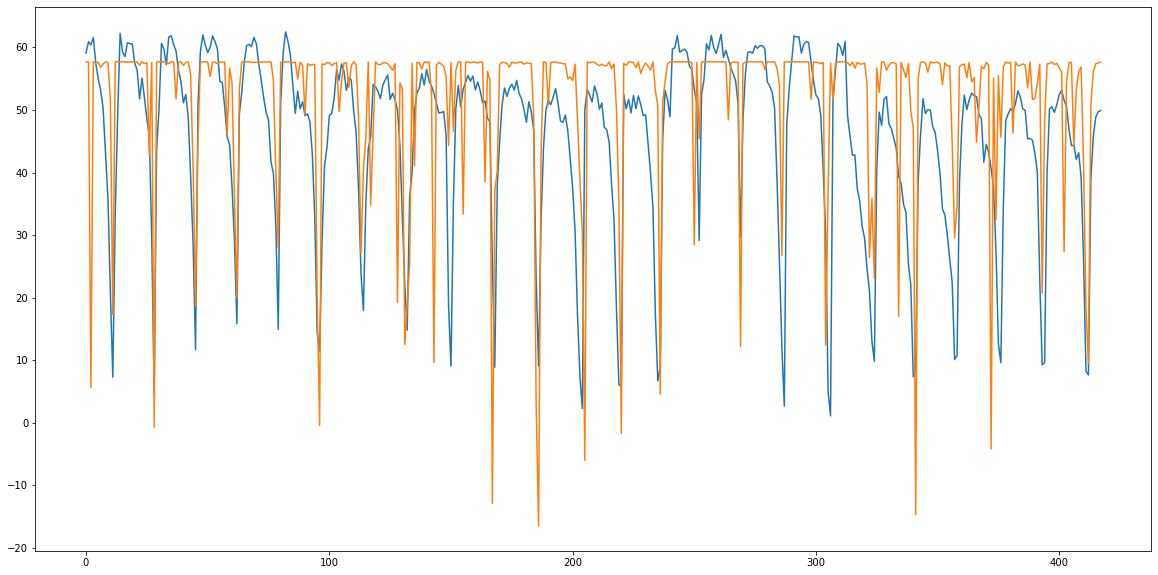

In [18]:
plot_pred(lpm, one_khz_examples)